In [1]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

import matplotlib.pyplot as plt  # type: ignore
from matplotlib.ticker import MaxNLocator  # type: ignore

from sklearn.manifold import TSNE  # type: ignore
from sklearn.decomposition import PCA  # type: ignore
from sklearn.preprocessing import StandardScaler  # type: ignore

from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import json
import lightgbm as lgb

import dask.dataframe as dd


dataset_params = {
        "SIFT100M": {
            "M": 32,
            "efC": 500,
            "efS": 500,
            "color": "lightblue",
            "marker": "o",
            "li": 1,
            "label": "SIFT100M"
        },
        "DEEP100M": {
            "M": 32,
            "efC": 500,
            "efS": 750,
            "color": "plum",
            "marker": "x",  
            "li": 1 ,
            "label": "DEEP100M"
        },
        "T2I100M": {
            "M": 80,
            "efC": 1000,
            "efS": 2500,
            "color": "rosybrown",
            "marker": "d",
            "li": 2,
            "label": "T2I100M"
        },
        "GLOVE100": {
            "M": 16,
            "efC": 500,
            "efS": 500,
            "color": "orange",
            "marker": "^",
            "li": 1,
            "label": "GLOVE1M"
        },
        "GIST1M": {
            "M": 32,
            "efC": 500,
            "efS": 1000,
            "color": "lightgreen",
            "marker": "s",
            "li": 1,
            "label": "GIST1M"
        },
    }

interval_conf = {}
with open("../../experiments/generated_json/final_heuristic_adaptive_recommendations_params_ipidiv2_mpidiv10.json") as f:
    interval_conf = json.load(f)

laet_multiplier_conf = {}
with open("../../experiments/generated_json/laet_tuning_results_memoryFalse_validationSize1000.json") as f:
    laet_multiplier_conf = json.load(f)

classic_hnsw_conf = {}
with open("../../experiments/generated_json/classic_hnsw_tuning_results_memoryFalse_validationSize1000.json") as f:
    classic_hnsw_conf = json.load(f)
    
algorithm_conf = {
    "Plain-HNSW":{
        "color": "red",
        "marker": "D",
        "label": "Plain-HNSW",
    },
    "Naive-Baseline": {
        "color": "black",
        "marker": "s",
        "label": "Baseline",
    },
    "LAET": {
        "color": "gray",
        "marker": "x",
        "label": "LAET",
    },
    "HNSW": {
        "color": "lightgray",
        "marker": "^",
        "label": "HNSW",
    },
    "DARTH": {
        "color": "tomato",
        "marker": "o",
        "label": "DARTH",
    },
}

def get_dataset_name(M, efC, efS, num_queries, ds_name, k, logint):
    return f"/data/mchatzakis/et_training_data/early-stop-training/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{num_queries}_li{logint}.txt"

PLOTS_DIR = "./../../experiments/revision-plots/"

In [2]:
dataset_params


{'SIFT100M': {'M': 32,
  'efC': 500,
  'efS': 500,
  'color': 'lightblue',
  'marker': 'o',
  'li': 1,
  'label': 'SIFT100M'},
 'DEEP100M': {'M': 32,
  'efC': 500,
  'efS': 750,
  'color': 'plum',
  'marker': 'x',
  'li': 1,
  'label': 'DEEP100M'},
 'T2I100M': {'M': 80,
  'efC': 1000,
  'efS': 2500,
  'color': 'rosybrown',
  'marker': 'd',
  'li': 2,
  'label': 'T2I100M'},
 'GLOVE100': {'M': 16,
  'efC': 500,
  'efS': 500,
  'color': 'orange',
  'marker': '^',
  'li': 1,
  'label': 'GLOVE1M'},
 'GIST1M': {'M': 32,
  'efC': 500,
  'efS': 1000,
  'color': 'lightgreen',
  'marker': 's',
  'li': 1,
  'label': 'GIST1M'}}

In [3]:
training_queries = 10000

ds_name = "DEEP100M"
M = dataset_params[ds_name]["M"]
efC = dataset_params[ds_name]["efC"]
efS = dataset_params[ds_name]["efS"]

k = 50
columns_to_load = ["qid", "dists", "r"]

all_queries_dask = dd.read_csv(get_dataset_name(M, efC, efS, training_queries, ds_name, k, 1), usecols=columns_to_load)
all_queries_data = all_queries_dask.compute()

all_queries_data.head()

,qid,dists,r
0,0,49,0.02
1,0,50,0.02
2,0,51,0.02
3,0,52,0.02
4,0,53,0.02


In [4]:
# For every q_id, keep the max recall entry, so that the dataset becomes qid->max_recall, with a single qid entry for each query
all_queries_data = all_queries_data.groupby("qid").max().reset_index()
all_queries_data.head()

,qid,dists,r
0,0,24992,1.00
1,1,30846,1.00
2,2,23001,1.00
3,3,7890,1.00
4,4,34092,0.98


In [5]:
# What percentange of the recalls is above 0.9?
print(f"Percentage of recalls above 0.9: {all_queries_data[all_queries_data['r'] > 0.9].shape[0] / all_queries_data.shape[0]}")

# What percentange of the recalls is above 0.95?
print(f"Percentage of recalls above 0.95: {all_queries_data[all_queries_data['r'] > 0.95].shape[0] / all_queries_data.shape[0]}")

# What percentange of the recalls is above 0.99?
print(f"Percentage of recalls above 0.99: {all_queries_data[all_queries_data['r'] > 0.99].shape[0] / all_queries_data.shape[0]}")

# What percentange of the recalls is above 0.85?
print(f"Percentage of recalls above 0.85: {all_queries_data[all_queries_data['r'] > 0.85].shape[0] / all_queries_data.shape[0]}")

Percentage of recalls above 0.9: 0.9944
Percentage of recalls above 0.95: 0.9843
Percentage of recalls above 0.99: 0.8938
Percentage of recalls above 0.85: 0.9981


Fig saved to ./../../experiments/revision-plots/learning_set_recall_DEEP100M_k50.pdf


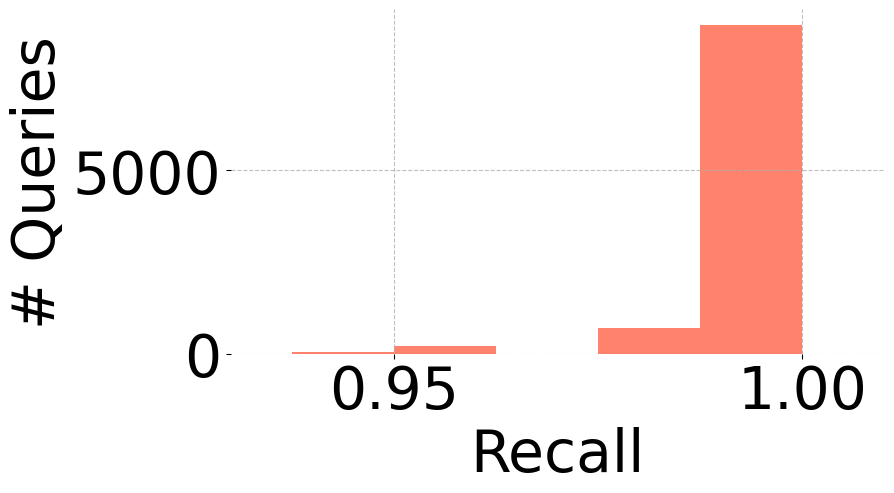

Fig saved to ./../../experiments/revision-plots/learning_set_dists_DEEP100M_k50.pdf


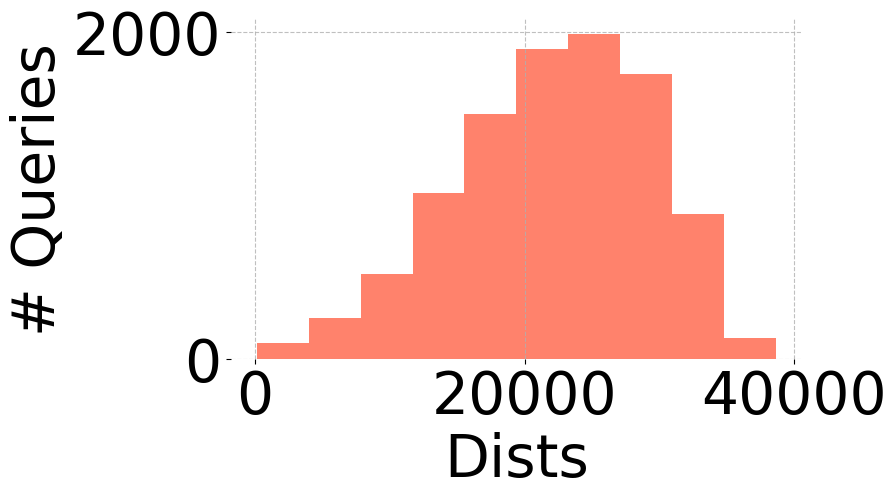

In [12]:
plt.rcParams.update({"font.size": 42}) 

recall_values = all_queries_data["r"].values
fig_recall, ax_recall = plt.subplots(figsize=(10, 6))
ax_recall.hist(recall_values, alpha=0.8, color="tomato", bins=80)
for spine in ax_recall.spines.values():
    spine.set_visible(False)

ax_recall.set_ylabel("# Queries")
ax_recall.set_xlabel(f"Recall")
ax_recall.grid(alpha=0.8, linestyle="--")
ax_recall.set_xlim(0.93, 1.01)
#ax_recall.tick_params(axis='x', labelsize=44)

fig_recall.tight_layout()
savepath = f"{PLOTS_DIR}learning_set_recall_{ds_name}_k{k}.pdf"
fig_recall.savefig(savepath, bbox_inches="tight")
print(f"Fig saved to {savepath}")
plt.show()
plt.close(fig_recall)

dists = all_queries_data["dists"].values
fig_dists, ax_dists = plt.subplots(figsize=(10, 6))
ax_dists.hist(dists, alpha=0.8, color="tomato", bins=10)
for spine in ax_dists.spines.values():
    spine.set_visible(False)
ax_dists.set_ylabel("# Queries")
ax_dists.set_xlabel(f"Dists")
ax_dists.grid(alpha=0.8, linestyle="--")
#ax_dists.tick_params(axis='x', labelsize=40)
fig_dists.tight_layout()
savepath = f"{PLOTS_DIR}learning_set_dists_{ds_name}_k{k}.pdf"
fig_dists.savefig(savepath, bbox_inches="tight")
print(f"Fig saved to {savepath}")
plt.show()
plt.close(fig_dists)